In [1]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')


In [2]:
import pickle


In [3]:
def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted
def calculate_histogram(array,weights,bins=9):
    bins_range = (-75, 75)
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in arctan
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


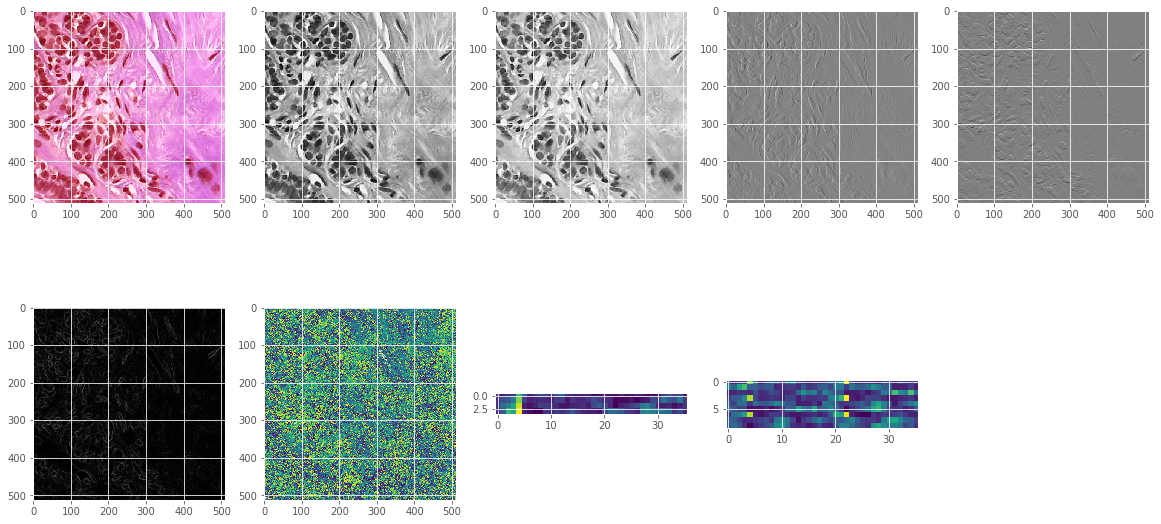

In [4]:

plt.figure(figsize=(20,10))

sample_image = cv2.imread('C:/Users/user/Desktop/Bitirme/VT/v1/Train/Normal/0_7.tif')
plt.subplot(2,5,1)
plt.imshow(sample_image)


# STEP 1 convert to gray
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)
plt.subplot(2,5,2)
plt.imshow(sample_image,cmap='gray')


# STEP 2 normalize
sample_image = sample_image ** 0.5
plt.subplot(2,5,3)
plt.imshow(sample_image,cmap='gray')

# STEP 3 calculate GX,GY
GX = translate(sample_image,1,0) - translate(sample_image,-1,0)
plt.subplot(2,5,4)
plt.imshow(GX,cmap='gray')

GY = translate(sample_image,0,1) - translate(sample_image,0,-1)
plt.subplot(2,5,5)
plt.imshow(GY,cmap='gray')

# STEP 4 calculate DELTA G and angle
delta_G = np.sqrt(GX ** 2 + GY ** 2)
plt.subplot(2,5,6)
plt.imshow(delta_G,cmap='gray')

angle = np.arctan(GY / GX) / np.pi * 180
plt.subplot(2,5,7)
plt.imshow(angle)

delta_G[angle == 0] = 0

# step 5 calcalute features
features = np.zeros((4,4,9))
for i in range(0,100,25):
    for j in range(0,100,25):
        features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])
        
plt.subplot(2,5,8)
plt.imshow(features.reshape(4,36))

# step 6 local normalize
one_feature = []
for i in range(3):
    for j in range(3):
        mat_norm = features[i:i + 2,j:j + 2]
        mag = np.linalg.norm(mat_norm)
        arr_list = (mat_norm / mag).flatten().tolist()
        one_feature += arr_list
plt.subplot(2,5,9)
plt.imshow(np.asarray(one_feature).reshape(9,-1))

In [5]:

len(one_feature)

324

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FC26A25940>]],
      dtype=object)

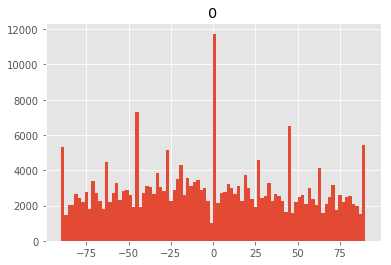

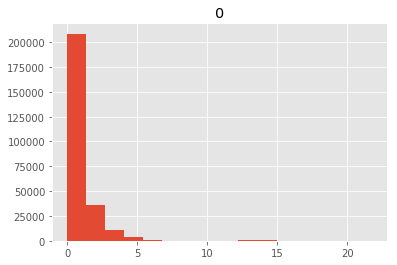

In [6]:
import pandas as pd
pd.DataFrame(angle.reshape(-1)).hist(bins=90)
pd.DataFrame(delta_G.reshape(-1)).hist(bins=16)

In [7]:
train_path = 'C:/Users/user/Desktop/Bitirme/VT/v1/Train'


In [8]:
def hog_feature(image):
    gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    fd,hog_img=hog(gray,orientations=8,pixels_per_cell=(64,64),cells_per_block=(4,4),block_norm='L2',visualise=True)
    return fd,hog_img

In [9]:
train_labels = os.listdir(train_path)
# sort the training labels
train_labels.sort()
print(train_labels)


['Benign', 'Insitu', 'Invasive', 'Normal']


In [10]:
labels = []
features = []
hog_images=[]

In [11]:
# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
import glob
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score

for training_name in train_labels:
    path = glob.glob("C:/Users/user/Desktop/Bitirme/VT/v1/Train/"+training_name+"/*.tif")

    
    # get the current training label
    current_label = training_name
    
    k = 1
    x=0
    # loop over the images in each sub-folder
    for file in path:
        if x<5800:
            image = cv2.imread(file)
            feature,hog_img = hog_feature(image)
            labels.append(current_label)
            features.append(feature)
            hog_images.append(hog_img)
            i += 1
            k += 1 
            x=x+1
    print ("[STATUS] processed folder: {}".format(current_label))
    j += 1

[STATUS] processed folder: Benign
[STATUS] processed folder: Insitu
[STATUS] processed folder: Invasive
[STATUS] processed folder: Normal


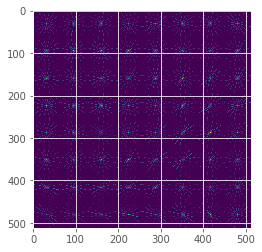

In [13]:
plt.imshow(hog_images[54])

In [14]:
len(features),len(labels)


(5837, 5837)

In [15]:
print ("[STATUS] completed Global Feature Extraction...")

# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(features).shape))

# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (5837, 3200)
[STATUS] training Labels (5837,)


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print ("[STATUS] training labels encoded...")

[STATUS] training labels encoded...


In [17]:
# normalize the feature vector in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(features)
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print( "[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (5837,)


In [18]:
rescaled_features= np.nan_to_num(rescaled_features,0)


In [19]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [ ]:
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=9)))
models.append(('DTC', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=300, random_state=9)))
models.append(('SVM', SVC(C=100,gamma=1)))

In [25]:
results = []
names = []
scoring = "accuracy"

In [26]:
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(rescaled_features),
                                                                                          np.array(target),
                                                                                          test_size=0.1,
                                                                                          random_state=9)

In [27]:
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.327427 (0.017364)
DTC: 0.606505 (0.018811)
RF: 0.674662 (0.014549)
SVM: 0.553966 (0.012940)


In [28]:
from sklearn import metrics
for name, model in models:
    clf=model
    clf.fit(trainDataGlobal, trainLabelsGlobal)
    y_pred=clf.predict(testDataGlobal)
    msg = "%s: %f " % (name, metrics.accuracy_score(y_pred,testLabelsGlobal))
    print(msg)

KNN: 0.301370 
DTC: 0.669521 
RF: 0.755137 
SVM: 0.635274 
